In [1]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

from idrf import IDRF #Deconvolution routine

In [2]:
from obspy.clients.fdsn.client import Client

client = Client('IRIS')

network = 'GT'
station = 'LBTB'

inv = client.get_stations(network=network, station=station,level='response')

sta = inv[0][0]
sta

Station LBTB (Lobatse, Botswana)
	Station Code: LBTB
	Channel Count: 66/66 (Selected/Total)
	1993-04-17T00:00:00.000000Z - 2599-12-31T23:59:59.000000Z
	Access: open 
	Latitude: -25.02, Longitude: 25.60, Elevation: 1148.3 m
	Available Channels:
		LBTB..BCI (2x), LBTB..BHZ (3x), LBTB..BHN (5x), LBTB..BHE (5x), 
		LBTB..LCI (2x), LBTB..LDO, LBTB..LEA, LBTB..LED, LBTB..LEP, 
		LBTB..LHZ (3x), LBTB..LHN (5x), LBTB..LHE (5x), LBTB..LID, LBTB..LKD
		LBTB..LKO, LBTB..LKP, LBTB..LWD, LBTB..LWS, LBTB..SCI (2x), 
		LBTB..SHZ (2x), LBTB..VHZ (3x), LBTB..VHN (5x), LBTB..VHE (5x), 
		LBTB.00.BHZ (2x), LBTB.00.BHN (2x), LBTB.00.BHE (2x), 
		LBTB.10.SHZ (3x)

In [3]:
import wget

!rm *.ndk

url = 'http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/jan76_dec17.ndk'
wget.download( url )


'jan76_dec17.ndk'

In [4]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = obspy.read_events('jan76_dec17.ndk')

/Users/mancinelli/anaconda/lib/python3.6/site-packages/obspy/io/ndk/core.py:205: ObsPyNDKWarning: Could not parse event 13965 (faulty file?). Will be skipped. Lines of the event:
	PDE  1996/11/20 19:42:56.1  10.30  127.43  33.0 5.6 5.3 PHILIPPINE ISLANDS REGIO
	B112096E         B: 35   58  45 S:  0    0   0 M:  0    0   0 CMT: 1 BOXHD: 22.0
	CENTROID:      1.060.0  10.47 0.03  127.42 0.03  15.0  0.0 BDY  O-00000000000000
	24 -4.983 0.133 -0.092 0.153  5.075 0.173 -0.433 0.443  0.715 0.469 -2.898 0.141
	V10   6.430  4 246  -1.390  2 156  -5.050 86  45   5.740 338 41  -88 154 49  -92
Traceback (most recent call last):
  File "/Users/mancinelli/anaconda/lib/python3.6/site-packages/obspy/io/ndk/core.py", line 197, in _read_ndk
    record = _read_lines(*lines)
  File "/Users/mancinelli/anaconda/lib/python3.6/site-packages/obspy/io/ndk/core.py", line 522, in _read_lines
    map(float, line3[:58].split()[1:])
ValueError: could not convert string to float: '1.060.0'

  warnings.warn(msg, ObsPy

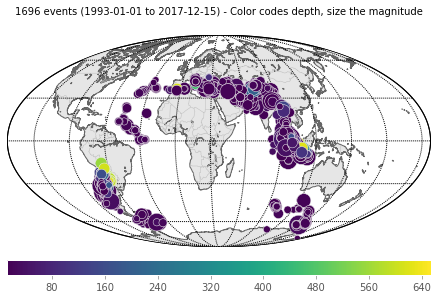

In [5]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = cat.filter("time > 1993-01-01T00:00").filter('magnitude >= 5.5')

cat2 = obspy.core.event.Catalog()

for evt in cat:
    elat=evt.origins[0].latitude
    elon=evt.origins[0].longitude
    slat=sta.latitude
    slon=sta.longitude
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg=delm/1000/111.11
    if deldeg > 55 and deldeg < 85:
        cat2.append(evt)
        
_ = cat2.plot()
    

In [39]:
from scipy.signal import tukey
from numpy import arange, linspace, zeros
from numpy.random import randn
from numpy import argmax, nan
import warnings
warnings.filterwarnings('ignore')

model = TauPyModel(model="iasp91")

#tries = linspace(0.5, 0.90, 5)
pctage=0.50

#tshifts = [-6, -3, 0, 3, 6]
tshifts = [0]

rbin    = zeros(len(tshifts)*len(cat2)*700).reshape(len(tshifts),len(cat2),700) * nan
rbin_s  = rbin.copy()
mbin1   = zeros(len(tshifts)*len(cat2)).reshape(len(tshifts),len(cat2)) * nan
mbin1_s = mbin1.copy()
mbin2   = mbin1.copy()
mbin2_s = mbin1.copy()

for ievt in range(len(cat2)):
    if ievt == 300:
        break
    
    print('Working on %5d of %5d' % (ievt+1,len(cat2)))

    strike=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
    dip=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
    rake=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake

    quake_depth_in_km=cat2[ievt].preferred_origin().depth/1000.0
    
    etime = cat2[ievt].preferred_origin().time

    slat=sta.latitude
    slon=sta.longitude
    elat=cat2[ievt].preferred_origin().latitude
    elon=cat2[ievt].preferred_origin().longitude

    client_syn = Client()
    
    t1=etime
    t2=etime+3600./2.

    for wvfrm_type in ['data','synthetic']:
        print(wvfrm_type)
        if wvfrm_type == 'synthetic'and data_download_success == False:
            break
    
        if wvfrm_type == 'synthetic':
            tmpstr = '%8.1f %8.1f %6.1f %8.1f %8.1f %8.2f %8.2f %8.2f ' % (elat, elon, quake_depth_in_km, slat, slon, strike, dip, rake)
            print(tmpstr)
            stis = client_syn.get_waveforms(model="iasp91_2s",
                                              sourcelatitude=elat,
                                              sourcelongitude=elon,
                                              sourcedepthinmeters=1000.*quake_depth_in_km,
                                              receiverlatitude=slat, receiverlongitude=slon,
                                              sourcedoublecouple=[strike,dip,rake],
                                              origintime=etime,
                                              units='velocity', starttime=t1, endtime=t2)
        else:
            #
            try:
                stis=client.get_waveforms(network,station,'*','LH?',t1,t2,attach_response=True)
                pre_filt = (0.005, 0.01, 5.0, 10.0)
                stis.remove_response(output='VEL', pre_filt=pre_filt)
            except:
                print('  get_waveforms failed.')
                break


            #

        print(stis)

        #print('...strike, dip, rake, elat, elon, quake_depth_in_km = %3d %3d %3d %5d %5d %5d %5d' % (strike, dip, rake, elat, elon, slat, quake_depth_in_km))


        delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
        deldeg=delm/1000/111.11

        arrivals = model.get_travel_times(source_depth_in_km=quake_depth_in_km, distance_in_degree=deldeg,phase_list=['S'])

        try:
            stis.rotate('->ZNE',inventory=inv)
            #stis.rotate('NE->RT', back_azimuth = baz)
            stis.rotate('ZNE->LQT', inclination=arrivals[0].incident_angle, back_azimuth = baz)
            stis.detrend()
            data_download_success = True
        except ValueError as e:
            print('Error: %s' % e)
            data_download_success = False
            break

        stis.filter('bandpass', freqmin = 1./100., freqmax = 1./8., zerophase=True)
        #stis.filter('highpass', freq=1./20., zerophase=True)
        stis.resample(5)
        stis.differentiate()

        t1=etime+arrivals[0].time - 50
        t2=etime+arrivals[0].time + 50

        for ii, tshift in enumerate(tshifts):

            
            stis2=stis.copy().trim(t1+tshift,t2+tshift)
            
            try:
                dt = stis2[0].stats.delta
            except IndexError as e:
                print(e)
                break
                
            try:
                assert 'L' in stis2[0].stats.channel
                assert 'Q' in stis2[1].stats.channel
                #assert 'T' in stis2[2].stats.channel
            except AssertionError as e:
                print(e)
                break
            except IndexError as e:
                print(e)
                break
            
            

            P = stis2[1].copy().data
            D = stis2[0].copy().data

            #Indeces to mask out
            i1 = int(len(P) * (pctage)/2)
            i2 = int(len(P) - i1)
            
            N1=P.copy()[:i1]
            N2=D.copy()[:i1]

            P[:i1]=0.0
            P[i2:]=0.0
            P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))
            
            if wvfrm_type == 'synthetic':
                pass
            else:
                smax  = max(abs(P))
                nmax1 = max(abs(N1))
                nmax2 = max(abs(N2))
    
            #print(i1,i2,imax)
            
            TB = 1.5
            NT = 2

            Poverlap = 0.99
            win_len  = 100

            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
            
            times, RF     = IDRF(P,D,dt)
            _,     RFnorm = IDRF(P,D,dt)
            
            #_, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

            if wvfrm_type == 'synthetic':
                rbin_s[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1_s[ii,ievt] = smax/nmax1
                mbin2_s[ii,ievt] = smax/nmax2
            else:
                rbin[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1[ii,ievt] = smax/nmax1
                mbin2[ii,ievt] = smax/nmax2
        

Working on     1 of  1696
data
  get_waveforms failed.
Working on     2 of  1696
data
  get_waveforms failed.
Working on     3 of  1696
data
  get_waveforms failed.
Working on     4 of  1696
data
  get_waveforms failed.
Working on     5 of  1696
data
  get_waveforms failed.
Working on     6 of  1696
data
  get_waveforms failed.
Working on     7 of  1696
data
  get_waveforms failed.
Working on     8 of  1696
data
  get_waveforms failed.
Working on     9 of  1696
data
  get_waveforms failed.
Working on    10 of  1696
data
  get_waveforms failed.
Working on    11 of  1696
data
  get_waveforms failed.
Working on    12 of  1696
data
  get_waveforms failed.
Working on    13 of  1696
data
  get_waveforms failed.
Working on    14 of  1696
data
  get_waveforms failed.
Working on    15 of  1696
data
  get_waveforms failed.
Working on    16 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1993-05-11T16:25:07.914000Z - 1993-05-11T16:55:06.914000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1993-05-11T

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-09-01T14:23:36.600000Z - 1993-09-01T14:25:16.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-09-01T14:23:36.600000Z - 1993-09-01T14:25:16.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-09-01T14:23:36.600000Z - 1993-09-01T14:25:16.500000Z | 10.0 Hz, 1000 samples
Working on    37 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1993-09-04T11:38:42.624000Z - 1993-09-04T12:08:41.624000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1993-09-04T11:38:42.624000Z - 1993-09-04T12:08:41.624000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1993-09-04T11:38:42.624000Z - 1993-09-04T12:08:41.624000Z | 1.0 Hz, 1800 samples
synthetic
    36.2     70.5  189.7    -25.0     25.6   268.00    24.00   121.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1993-09-04T11:58:27.000000Z - 1993-09-04T12:00:06.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1993-09-04T11:58:27.000000Z - 1993-09-04T12:00:06.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1993-09-04T11:58

  get_waveforms failed.
Working on    56 of  1696
data
  get_waveforms failed.
Working on    57 of  1696
data
  get_waveforms failed.
Working on    58 of  1696
data
  get_waveforms failed.
Working on    59 of  1696
data
  get_waveforms failed.
Working on    60 of  1696
data
  get_waveforms failed.
Working on    61 of  1696
data
  get_waveforms failed.
Working on    62 of  1696
data
  get_waveforms failed.
Working on    63 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1994-04-16T09:55:26.440000Z - 1994-04-16T10:25:25.440000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1994-04-16T09:55:26.440000Z - 1994-04-16T10:25:25.440000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1994-04-16T09:55:26.440000Z - 1994-04-16T10:25:25.440000Z | 1.0 Hz, 1800 samples
synthetic
   -32.2    -71.8   31.3    -25.0     25.6    10.00    26.00   108.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-04-16T10:17:15.400000Z - 1994-04-16T10:18:55.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-04-16T10:17:15.400000Z -

synthetic
    -9.2    106.5   41.1    -25.0     25.6    64.00    66.00  -165.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-09-12T11:51:14.500000Z - 1994-09-12T11:52:54.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-09-12T11:51:14.500000Z - 1994-09-12T11:52:54.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1994-09-12T11:51:14.500000Z - 1994-09-12T11:52:54.400000Z | 10.0 Hz, 1000 samples
Working on   104 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1994-09-17T12:22:20.986000Z - 1994-09-17T12:52:19.986000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1994-09-17T12:22:20.986000Z - 1994-09-17T12:52:19.986000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1994-09-17T12:22:20.985000Z - 1994-09-17T12:52:19.985000Z | 1.0 Hz, 1800 samples
synthetic
   -32.5    -72.0   18.8    -25.0     25.6    11.00    26.00    83.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1994-09-17T12:44:13.100000Z - 1994-09-17T12:45:53.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1994-09-17T12:44:13.100000Z - 1994-

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-02-03T02:53:47.700000Z - 1995-02-03T02:55:27.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-02-03T02:53:47.700000Z - 1995-02-03T02:55:27.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-02-03T02:53:47.700000Z - 1995-02-03T02:55:27.600000Z | 10.0 Hz, 1000 samples
Working on   118 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1995-02-14T15:54:02.578000Z - 1995-02-14T16:24:01.578000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1995-02-14T15:54:02.578000Z - 1995-02-14T16:24:01.578000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1995-02-14T15:54:02.578000Z - 1995-02-14T16:24:01.578000Z | 1.0 Hz, 1800 samples
synthetic
   -23.6    -67.9  159.5    -25.0     25.6   143.00    18.00  -115.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-02-14T16:15:28.700000Z - 1995-02-14T16:17:08.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-02-14T16:15:28.700000Z - 1995-02-14T16:17:08.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-02-14T16:15

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-06-15T00:34:02.100000Z - 1995-06-15T00:35:42.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-06-15T00:34:02.100000Z - 1995-06-15T00:35:42.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-06-15T00:34:02.100000Z - 1995-06-15T00:35:42.000000Z | 10.0 Hz, 1000 samples
Working on   134 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1995-06-21T15:29:00.599000Z - 1995-06-21T15:58:59.599000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1995-06-21T15:29:00.599000Z - 1995-06-21T15:58:59.599000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1995-06-21T15:29:00.599000Z - 1995-06-21T15:58:59.599000Z | 1.0 Hz, 1800 samples
synthetic
   -61.9    154.5   15.0    -25.0     25.6    64.00    88.00   180.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-06-21T15:51:06.500000Z - 1995-06-21T15:52:46.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-06-21T15:51:06.500000Z - 1995-06-21T15:52:46.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-06-21T15:51

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-10-22T20:14:45.400000Z - 1995-10-22T20:16:25.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-10-22T20:14:45.400000Z - 1995-10-22T20:16:25.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-10-22T20:14:45.400000Z - 1995-10-22T20:16:25.300000Z | 10.0 Hz, 1000 samples
Working on   148 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1995-10-31T01:56:04.750000Z - 1995-10-31T02:26:03.750000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1995-10-31T01:56:04.750000Z - 1995-10-31T02:26:03.750000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1995-10-31T01:56:04.750000Z - 1995-10-31T02:26:03.750000Z | 1.0 Hz, 1800 samples
synthetic
   -28.9    -71.5   15.0    -25.0     25.6    20.00    11.00   128.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1995-10-31T02:18:09.100000Z - 1995-10-31T02:19:49.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1995-10-31T02:18:09.100000Z - 1995-10-31T02:19:49.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1995-10-31T02:18

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-03-09T22:56:39.100000Z - 1996-03-09T22:58:19.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-03-09T22:56:39.100000Z - 1996-03-09T22:58:19.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-03-09T22:56:39.100000Z - 1996-03-09T22:58:19.000000Z | 10.0 Hz, 1000 samples
Working on   164 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1996-03-19T15:00:36.537000Z - 1996-03-19T15:30:35.537000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1996-03-19T15:00:36.537000Z - 1996-03-19T15:30:35.537000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1996-03-19T15:00:36.537000Z - 1996-03-19T15:30:35.537000Z | 1.0 Hz, 1800 samples
synthetic
    39.9     76.8   22.2    -25.0     25.6   273.00    26.00   109.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-03-19T15:22:01.700000Z - 1996-03-19T15:23:41.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-03-19T15:22:01.700000Z - 1996-03-19T15:23:41.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-03-19T15:22

3 Trace(s) in Stream:
GT.LBTB..LHE | 1996-09-05T20:44:18.247040Z - 1996-09-05T21:14:17.247040Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1996-09-05T20:44:18.247042Z - 1996-09-05T21:14:17.247042Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1996-09-05T20:44:18.247039Z - 1996-09-05T21:14:17.247039Z | 1.0 Hz, 1800 samples
synthetic
    42.8     17.8   15.0    -25.0     25.6   328.00    32.00    92.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1996-09-05T21:03:24.500000Z - 1996-09-05T21:05:04.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1996-09-05T21:03:24.500000Z - 1996-09-05T21:05:04.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1996-09-05T21:03:24.500000Z - 1996-09-05T21:05:04.400000Z | 10.0 Hz, 1000 samples
Working on   176 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1996-09-09T00:20:45.247024Z - 1996-09-09T00:50:44.247024Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1996-09-09T00:20:45.247022Z - 1996-09-09T00:50:44.247022Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1996-09-09T00:20:45.247022Z

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-01-21T02:09:51.000000Z - 1997-01-21T02:11:30.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-01-21T02:09:51.000000Z - 1997-01-21T02:11:30.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-01-21T02:09:51.000000Z - 1997-01-21T02:11:30.900000Z | 10.0 Hz, 1000 samples
Working on   195 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-01-22T17:57:25.123047Z - 1997-01-22T18:27:24.123047Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-01-22T17:57:25.123047Z - 1997-01-22T18:27:24.123047Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-01-22T17:57:25.123027Z - 1997-01-22T18:27:24.123027Z | 1.0 Hz, 1800 samples
synthetic
    36.0     35.8   15.0    -25.0     25.6   243.00    39.00   -15.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-01-22T18:15:12.800000Z - 1997-01-22T18:16:52.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-01-22T18:15:12.800000Z - 1997-01-22T18:16:52.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-01-22T18:15

3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-04-05T23:46:23.588000Z - 1997-04-06T00:16:22.588000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-04-05T23:46:23.588000Z - 1997-04-06T00:16:22.588000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-04-05T23:46:23.588000Z - 1997-04-06T00:16:22.588000Z | 1.0 Hz, 1800 samples
synthetic
    39.4     76.9   33.0    -25.0     25.6   161.00    78.00   179.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-04-06T00:07:42.300000Z - 1997-04-06T00:09:22.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-04-06T00:07:42.300000Z - 1997-04-06T00:09:22.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-04-06T00:07:42.300000Z - 1997-04-06T00:09:22.200000Z | 10.0 Hz, 1000 samples
Working on   210 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-04-06T04:36:38.587052Z - 1997-04-06T05:06:37.587052Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-04-06T04:36:38.587052Z - 1997-04-06T05:06:37.587052Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-04-06T04:36:38.587066Z

3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-06-02T21:09:07.636091Z - 1997-06-02T21:39:06.636091Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-06-02T21:09:07.636091Z - 1997-06-02T21:39:06.636091Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-06-02T21:09:07.636005Z - 1997-06-02T21:39:06.636005Z | 1.0 Hz, 1800 samples
synthetic
   -52.8    140.9   15.0    -25.0     25.6   265.00    64.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-06-02T21:31:14.600000Z - 1997-06-02T21:32:54.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-06-02T21:31:14.600000Z - 1997-06-02T21:32:54.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-06-02T21:31:14.600000Z - 1997-06-02T21:32:54.500000Z | 10.0 Hz, 1000 samples
Working on   225 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-06-11T19:12:31.635061Z - 1997-06-11T19:42:30.635061Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-06-11T19:12:31.635061Z - 1997-06-11T19:42:30.635061Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-06-11T19:12:31.635042Z

synthetic
   -29.5    -72.0   32.9    -25.0     25.6   315.00    47.00    40.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-07-19T12:45:05.500000Z - 1997-07-19T12:46:45.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-07-19T12:45:05.500000Z - 1997-07-19T12:46:45.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-07-19T12:45:05.500000Z - 1997-07-19T12:46:45.400000Z | 10.0 Hz, 1000 samples
Working on   236 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-07-20T10:14:29.636000Z - 1997-07-20T10:44:28.636000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-07-20T10:14:29.636000Z - 1997-07-20T10:44:28.636000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-07-20T10:14:29.636000Z - 1997-07-20T10:44:28.636000Z | 1.0 Hz, 1800 samples
synthetic
   -22.8    -66.1  271.3    -25.0     25.6   289.00    24.00   -39.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-07-20T10:35:22.700000Z - 1997-07-20T10:37:02.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-07-20T10:35:22.700000Z - 1997-

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-08-24T13:34:33.800000Z - 1997-08-24T13:36:13.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-08-24T13:34:33.800000Z - 1997-08-24T13:36:13.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-08-24T13:34:33.800000Z - 1997-08-24T13:36:13.700000Z | 10.0 Hz, 1000 samples
Working on   247 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-09-26T00:33:19.297017Z - 1997-09-26T01:03:18.297017Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-09-26T00:33:19.297018Z - 1997-09-26T01:03:18.297018Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-09-26T00:33:19.297016Z - 1997-09-26T01:03:18.297016Z | 1.0 Hz, 1800 samples
synthetic
    43.0     12.9   15.0    -25.0     25.6   156.00    38.00   -71.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-09-26T00:52:36.300000Z - 1997-09-26T00:54:16.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-09-26T00:52:36.300000Z - 1997-09-26T00:54:16.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-09-26T00:52

3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-11-08T10:03:04.298050Z - 1997-11-08T10:33:03.298050Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-11-08T10:03:04.298047Z - 1997-11-08T10:33:03.298047Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-11-08T10:03:04.298019Z - 1997-11-08T10:33:03.298019Z | 1.0 Hz, 1800 samples
synthetic
    35.3     87.0   16.4    -25.0     25.6    79.00    69.00     2.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1997-11-08T10:25:03.100000Z - 1997-11-08T10:26:43.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1997-11-08T10:25:03.100000Z - 1997-11-08T10:26:43.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1997-11-08T10:25:03.100000Z - 1997-11-08T10:26:43.000000Z | 10.0 Hz, 1000 samples
Working on   259 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1997-11-14T10:18:27.298005Z - 1997-11-14T10:48:26.298005Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1997-11-14T10:18:27.298005Z - 1997-11-14T10:48:26.298005Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1997-11-14T10:18:27.298005Z

3 Trace(s) in Stream:
GT.LBTB..LHE | 1998-03-14T19:40:34.823083Z - 1998-03-14T20:10:33.823083Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1998-03-14T19:40:34.823090Z - 1998-03-14T20:10:33.823090Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1998-03-14T19:40:34.823057Z - 1998-03-14T20:10:33.823057Z | 1.0 Hz, 1800 samples
synthetic
    29.9     57.6   15.0    -25.0     25.6   154.00    57.00  -174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1998-03-14T19:58:38.300000Z - 1998-03-14T20:00:18.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1998-03-14T19:58:38.300000Z - 1998-03-14T20:00:18.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1998-03-14T19:58:38.300000Z - 1998-03-14T20:00:18.200000Z | 10.0 Hz, 1000 samples
Working on   274 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1998-03-19T13:51:39.648000Z - 1998-03-19T14:21:38.648000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1998-03-19T13:51:39.648000Z - 1998-03-19T14:21:38.648000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1998-03-19T13:51:39.648000Z

3 Trace(s) in Stream:
GT.LBTB..LHE | 1998-05-22T04:49:02.998096Z - 1998-05-22T05:19:01.998096Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1998-05-22T04:49:02.998094Z - 1998-05-22T05:19:01.998094Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1998-05-22T04:49:02.998094Z - 1998-05-22T05:19:01.998094Z | 1.0 Hz, 1800 samples
synthetic
   -17.6    -65.2   15.0    -25.0     25.6   186.00    79.00  -178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1998-05-22T05:11:01.700000Z - 1998-05-22T05:12:41.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1998-05-22T05:11:01.700000Z - 1998-05-22T05:12:41.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1998-05-22T05:11:01.700000Z - 1998-05-22T05:12:41.600000Z | 10.0 Hz, 1000 samples
Working on   286 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1998-05-24T02:32:54.998005Z - 1998-05-24T03:02:53.998005Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1998-05-24T02:32:54.998005Z - 1998-05-24T03:02:53.998005Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1998-05-24T02:32:54.998005Z

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1998-07-20T01:27:44.700000Z - 1998-07-20T01:29:24.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1998-07-20T01:27:44.700000Z - 1998-07-20T01:29:24.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1998-07-20T01:27:44.700000Z - 1998-07-20T01:29:24.600000Z | 10.0 Hz, 1000 samples
Working on   297 of  1696
data
3 Trace(s) in Stream:
GT.LBTB..LHE | 1998-07-29T07:14:28.998000Z - 1998-07-29T07:44:27.998000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHN | 1998-07-29T07:14:28.998000Z - 1998-07-29T07:44:27.998000Z | 1.0 Hz, 1800 samples
GT.LBTB..LHZ | 1998-07-29T07:14:28.998000Z - 1998-07-29T07:44:27.998000Z | 1.0 Hz, 1800 samples
synthetic
   -32.3    -71.7   58.0    -25.0     25.6   181.00    40.00   116.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 1998-07-29T07:36:10.500000Z - 1998-07-29T07:37:50.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 1998-07-29T07:36:10.500000Z - 1998-07-29T07:37:50.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 1998-07-29T07:36

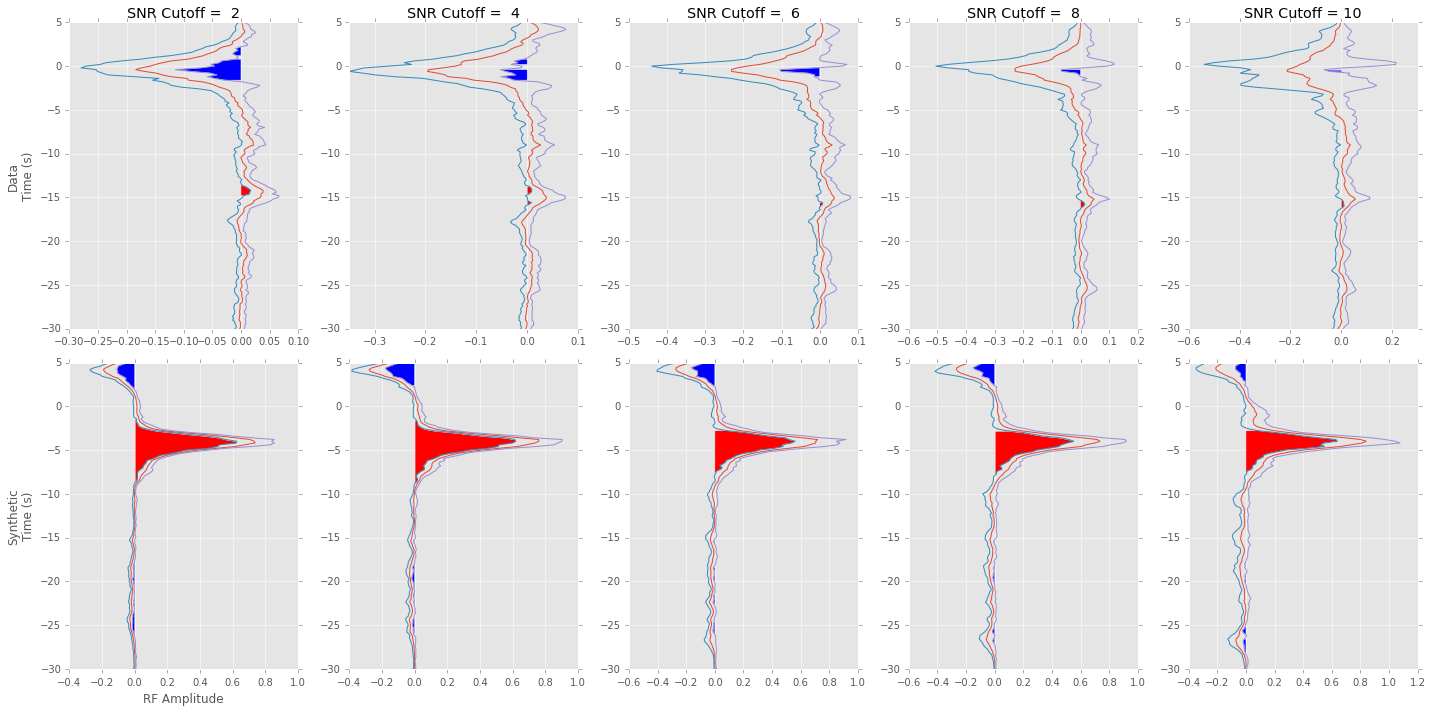

In [40]:
from numpy import nanmean, nanmedian, nanstd
from numpy.random import choice

#times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

#nrfs = len(cat2)
#nrfs = 329

minsnrs = arange(2, 12, 2)

#rbin_sn = rbin_s.copy() + randn(rbin_s.shape[0],rbin_s.shape[1],rbin_s.shape[2])*0.05

for iplt, minsnr in enumerate(minsnrs):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        snr_sample = arange(len(cat2))[mbin1[0,:]>minsnr]
        
        nrfs = len(snr_sample)
        
        rbin1=rbin0[0,snr_sample,:]
        
        nboot = 500

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        for iboot in range(nboot):
            random_sample = choice(range(nrfs), nrfs, replace=True)
            bbin[iboot,:] = nanmedian(rbin1[random_sample,:len(RF)],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(minsnrs),iplt+1)
        else:
            plt.subplot(2,len(minsnrs),iplt+1+len(minsnrs))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        if irow == 0:
            plt.title('SNR Cutoff = %2d' % (minsnr) )

plt.subplot(2,len(minsnrs),1)
plt.ylabel('Data\nTime (s)')
plt.subplot(2,len(minsnrs),1+len(minsnrs))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')

#plt.ylabel('Time (s)')
#plt.xlabel('RF Amplitude')
    
plt.tight_layout()
plt.savefig('%s_SNR.eps' % station)

(array([  1.42100000e+03,   1.06000000e+02,   5.90000000e+01,
          5.70000000e+01,   1.10000000e+01,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   2.10000000e+01,
          1.80000000e+01]),
 array([  12.  ,   76.12,  140.24,  204.36,  268.48,  332.6 ,  396.72,
         460.84,  524.96,  589.08,  653.2 ]),
 <a list of 10 Patch objects>)

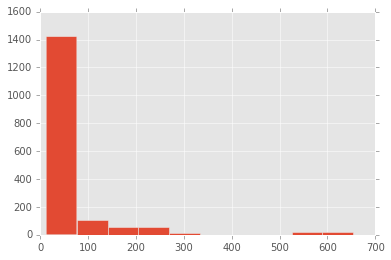

In [8]:
tmp=[]
for ievt, evt in enumerate(cat2):
    elat=evt.preferred_origin().latitude
    elon=evt.preferred_origin().longitude
    edep=evt.preferred_origin().depth/1000.0
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg = delm/1000./111.11
    tmp.append(edep)
    
plt.hist(tmp)

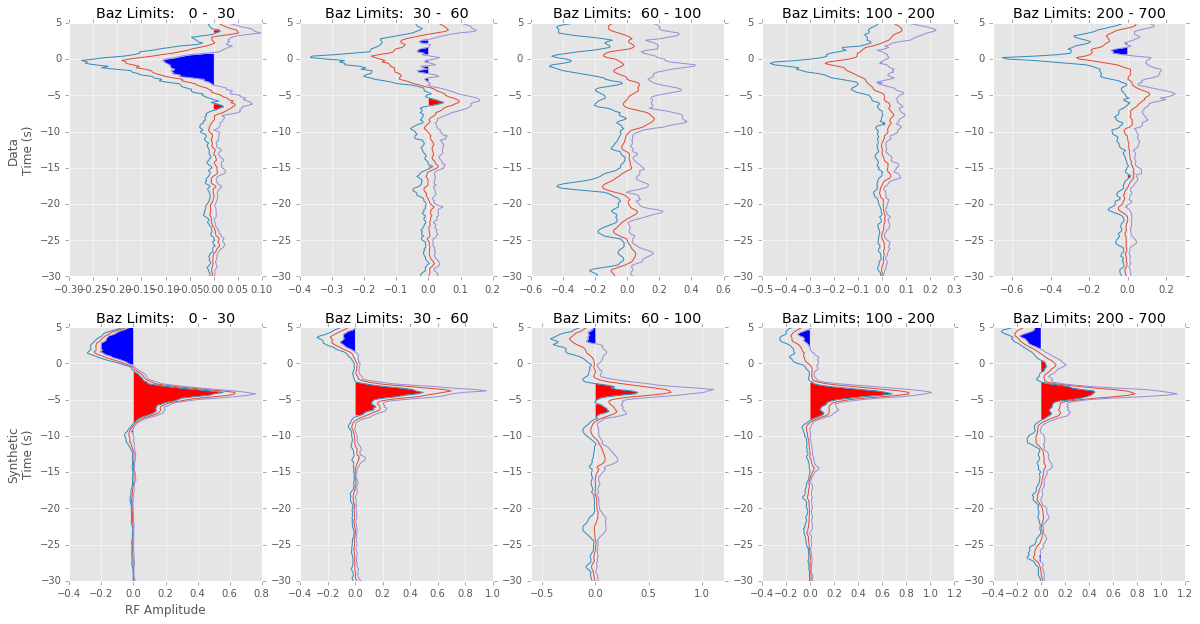

In [9]:
from numpy import nanmean, nanmedian, nanstd, array, shape
from numpy.random import choice

#times, RF = IDRF(P,D,dt)


depthranges = [(0,30),(30,60),(60,100),(100,200),(200,700)]

iplt = 4

for iplt, depthrange in enumerate(depthranges):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        dmin, dmax = depthrange[0], depthrange[1]

        slic = array(array(tmp) > dmin) & array(array(tmp) < dmax)

        #print(dmin, dmax, len(slic))

        nboot = 100

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        rbin2 = rbin0[0,slic,:len(RF)]
        nrf,_ = shape(rbin2)

        for iboot in range(nboot):

            random_sample = choice(range(nrf), nrf, replace=True)

            #print(nrf, len(random_sample))

            bbin[iboot,:] = nanmedian(rbin2[random_sample,:],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(depthranges),iplt+1)
        else:
            plt.subplot(2,len(depthranges),iplt+1+len(depthranges))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        #plt.xlim(-0.3,0.3)
        plt.title('Baz Limits: %3d - %3d' % (dmin, dmax))

plt.subplot(2,len(depthranges),1)
plt.ylabel('Data\nTime (s)')
        
plt.subplot(2,len(depthranges),1+len(depthranges))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')
    
#plt.tight_layout()
plt.savefig('%s_baz_limted.eps' % station)

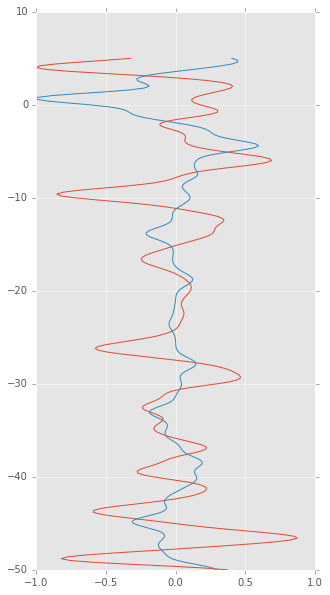

In [38]:

plt.figure(1,(5,10))
plt.plot(rbin[0,255,:len(RF)],times)
plt.plot(rbin_s[0,255,:len(RF)],times)